# **DBSCAN**

El dbscan se define un epsilon (radio) y lo que hace es escoger un punto random y ve cuantos puntos estan dentro del circulo para detemrinar si es un "CORE" o si es "RUIDO".

Puntos contiguos a las áreas "CORE", se seleccionan cuales puntos de ruido son "CORE".

Un cluster son las regiones epsilon contiguas, los puntos "core" cerca.

Una forma para ver si los puntos estan adentro es con distancia euclidiana.

$d(P,Q) = \sqrt{(X_Q-X_P)^2+(Y_Q-Y_P)^2}$
y el resltado tendria que ser $d(P, Q) \leq \epsilon$

In [1]:
import pandas as pd
from sklearn import datasets
import random
import math
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from collections import Counter

In [2]:
iris = datasets.load_iris()

df = pd.DataFrame(
    iris.data,
    columns=iris.feature_names
    )

#PCA descomposición para tener un (x,y)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
pca = PCA(n_components = 2)
arr_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(arr_pca, columns=["X", "Y"])

In [3]:
def euclidian(df):
  distancias = pdist(df.values, metric="euclidean")
  return squareform(distancias)

Implementando DBSCAN manual

In [4]:
def DBSCAN_manual(df_pca, epsilon, min_samples):
  t = pd.DataFrame(euclidian(df_pca)) # La funcion la ya la teniamos de arriba. Sacas las distancias para cada punto

  # enucnetra cores
  df_pca["Conteo"] = (t <= epsilon).sum() # num dentro
  df_pca["isCore"] = (t <= epsilon).sum() >= min_samples # Cumple o no cumple

  # para cada fila, voy a contar sus vecinos (obtener su indice) y luego voy a obtener si algun vecion es CORE
  lista = []
  for i in range(t.shape[0]):
    res =df_pca.loc[(t[i] <= epsilon), 'isCore'].any() # Si esto es false es RUIDO # Si hay al menos 1 true, es FRONTERA
    lista.append(res)
  df_pca["isFrontera"] = lista
  df_pca["FINAL"] = df_pca["isCore"].astype(int) + df_pca["isFrontera"].astype(int) # Si es 2 es core, si es 1 es frontera, si es 0 es ruido

  return df_pca

In [5]:
epsilon = 0.5 #radio
min_samples = 10 #cuantos puntos para determinar si un area es "densa"
clusters_eu = DBSCAN(eps=epsilon, min_samples=min_samples, metric="euclidean").fit_predict(df_pca)
dbscan_results = DBSCAN_manual(df_pca, epsilon, min_samples)

Text(0.5, 1.0, 'Resultados DBSCAN encontrando CORES')

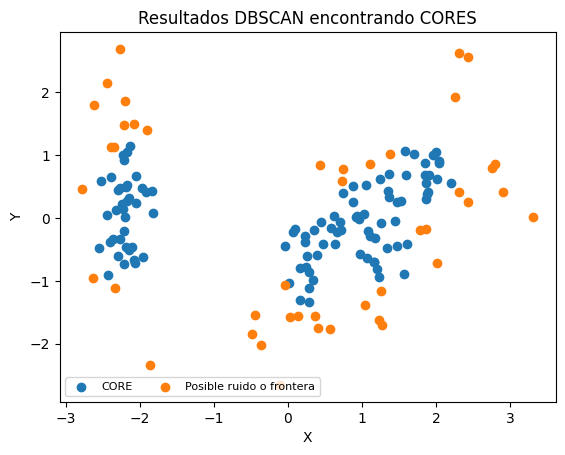

In [6]:
core = plt.scatter(dbscan_results[dbscan_results["isCore"] == True]["X"], dbscan_results[dbscan_results["isCore"] == True]["Y"])
desconocido = plt.scatter(dbscan_results[dbscan_results["isCore"] == False]["X"], dbscan_results[dbscan_results["isCore"] == False]["Y"])

plt.legend((core, desconocido),
           ('CORE', 'Posible ruido o frontera'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Resultados DBSCAN encontrando CORES')
# Estamos viendo en la grafica los puntos azules que son CORE.
# Los puntos naranjas estan por definirse

Text(0.5, 1.0, 'Resultados DBSCAN')

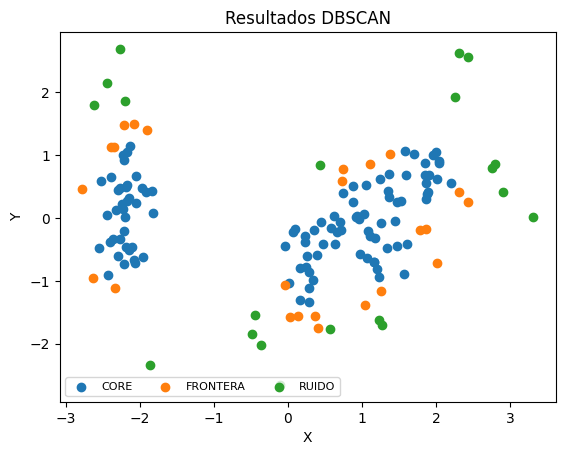

In [7]:
core = plt.scatter(dbscan_results[dbscan_results["FINAL"] == 2]["X"], dbscan_results[dbscan_results["FINAL"] == 2]["Y"])
frontera = plt.scatter(dbscan_results[dbscan_results["FINAL"] == 1]["X"], dbscan_results[dbscan_results["FINAL"] == 1]["Y"])
ruido  = plt.scatter(dbscan_results[dbscan_results["FINAL"] == 0]["X"], dbscan_results[dbscan_results["FINAL"] == 0]["Y"])


plt.legend((core, frontera, ruido),
           ('CORE', 'FRONTERA', "RUIDO"),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Resultados DBSCAN')

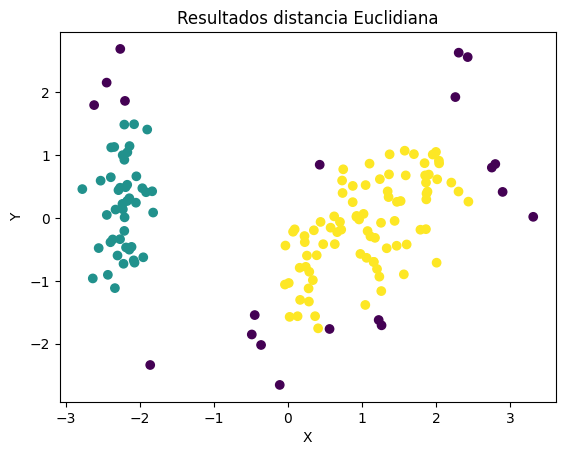

In [8]:
# comparando contra la librería
plt.scatter(df_pca["X"], df_pca['Y'], c=clusters_eu)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Resultados distancia Euclidiana')
plt.show()
# Los -1 son ruido
# A partir de 0 son clusters

Alcance: Identificando Ruido

In [9]:
# Con libreria
print(f"Hubo {(clusters_eu <0).sum()} puntos clasificados como ruido con la librería")
# Mi función
conteo = dbscan_results["FINAL"][dbscan_results["FINAL"] == 0].count()
print(f"Hubo {conteo} puntos clasificados como ruido con mi función")

Hubo 20 puntos clasificados como ruido con la librería
Hubo 20 puntos clasificados como ruido con mi función


Desglose

In [10]:
Counter(clusters_eu)

Counter({0: 45, -1: 20, 1: 85})

In [11]:
dbscan_results["FINAL"].value_counts()

2    106
1     24
0     20
Name: FINAL, dtype: int64